In [1]:
#Importar librerias
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [2]:
#Importar los datos en un dataframe
data = pd.read_csv('./facebook-grupo.csv',sep= ";", encoding = 'latin-1', decimal =",")
data['Fecha']=pd.to_datetime(data['Fecha'],format="%d-%m-%Y %H:%M:%S")

#Limpiar los datos y ajustar el formato de la fecha
data = data.dropna(subset=['Fecha'])
data['mes']=data['Fecha'].apply(lambda x: f'{x.month}-{x.year}')

In [3]:
#Pasar mes a datetime y crear columna demanda
data['mes2']= data['mes'].apply(lambda x: datetime.strptime(x,"%m-%Y"))
data['demanda']=data['Comentarios']+data['Likes']

In [4]:
#Crear la pivot table de los datos
pdata = pd.pivot_table(data,values=['PageID','demanda'],index='mes2',aggfunc={'PageID':'count','demanda':'sum'})
pdata = pdata.rename(columns={'PageID':'oferta'})

#Eliminar valor atipico
pdata.drop(datetime(2020,7,1),inplace=True)

#modelar datos vacios
idx = pd.date_range(start=pdata.index.min(),end = pdata.index.max(),freq = 'MS')
pdata = pdata.reindex(idx)
pdata['demanda'].interpolate(method='cubic',inplace=True)
pdata['oferta'].interpolate(method='cubic',inplace=True)

#definir scaler y escalar demanda, oferta y equilibrio
scaler = preprocessing.StandardScaler()
pdata[['demanda','oferta']]= scaler.fit_transform(pdata[['demanda','oferta']])
pdata['equi'] = pdata['demanda'].abs()/pdata['oferta'].abs()
pdata['equi'] = pdata['demanda']/pdata['oferta']



  feature  importance
0   lag_1   -0.164586
1   lag_2   -0.264379
2   lag_3   -0.070615
3   lag_4   -0.086946
4   lag_5   -0.044751
5   lag_6   -0.029506
6   lag_7    0.006223
7   lag_8    0.045115
Error de test (mse): 2.3537802621571147


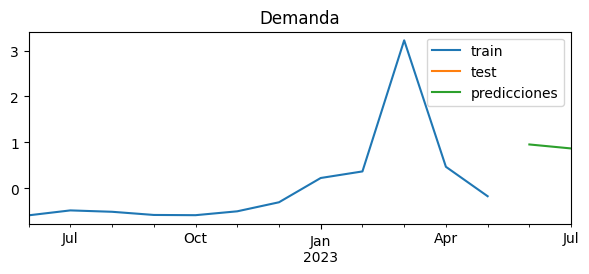

In [23]:
#definir series de datos para el forecast, dejando el ultimo dato como evaluador
d_train = pd.Series(pdata['demanda'])[:-1]
o_train = pd.Series(pdata['oferta'])[:-1]
d_test = pd.Series(pdata['demanda'])[-1:]
o_test = pd.Series(pdata['oferta'])[-1:]

#Definición de la función de predicción y ajuste para la demanda
d_forecaster = ForecasterAutoreg(
                regressor = Ridge(alpha= 4),
                lags=8)
d_forecaster.fit(y= pd.Series(d_train))
print(d_forecaster.get_feature_importances())

#Predicción de los dos pasos futuros de la demanda
d_pred = d_forecaster.predict(steps=2)

error_mse = mean_squared_error(
                y_true = d_test,
                y_pred = d_pred[:1]
            )

print(f"Error de test (mse): {error_mse}")

#Graficar
fig, ax = plt.subplots(figsize=(7, 2.5))
d_train.plot(ax=ax, label='train')
d_test.plot(ax=ax, label='test')
d_pred.plot(ax=ax, label='predicciones')
ax.set_title('Demanda')
ax.legend()

  feature  importance
0   lag_1   -0.040010
1   lag_2   -0.020730
2   lag_3    0.058697
3   lag_4   -0.311267
4   lag_5   -0.262440
5   lag_6   -0.118965
6   lag_7   -0.003569
7   lag_8    0.063208
Error de test (mse): 1.1617740400781442


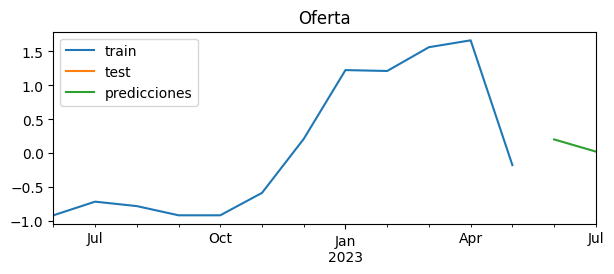

In [20]:
#Definición de la función de predicción y ajuste para la oferta
o_forecaster = ForecasterAutoreg(
                regressor = Ridge(alpha=2),
                lags=8)
o_forecaster.fit(y= pd.Series(o_train))
print(o_forecaster.get_feature_importances())

#Predicción de los dos pasos futuros de la oferta
o_pred = o_forecaster.predict(steps=2)

error_mse = mean_squared_error(
                y_true = o_test,
                y_pred = o_pred[:1]
            )

print(f"Error de test (mse): {error_mse}")

#Graficar
fig, ax = plt.subplots(figsize=(7, 2.5))
o_train.plot(ax=ax, label='train')
o_test.plot(ax=ax, label='test')
o_pred.plot(ax=ax, label='predicciones')
ax.set_title('Oferta')
ax.legend()

In [7]:
#Definir fechas que coinciden en la predicción y los datos originales
index1 = pdata.index.values
index2 = d_pred.index.values
igual = [x for x in index1 if x in index2]

#eliminar coincidencias de los datos originales
data_pred = pdata.drop(igual)

d_pred.rename('demanda',inplace=True)
o_pred.rename('oferta', inplace=True)

#Unir datos de predicción y concatenar en una tabla con los originales
prediction = pd.merge(pd.DataFrame(d_pred),pd.DataFrame(o_pred),how='left',left_index=True,right_index=True)
data_pred = pd.concat([data_pred,prediction])
data_pred['equi']=data_pred['demanda'].abs()/data_pred['oferta'].abs()

In [8]:
#Exportar datos, formato para cargar en googlesheets
data_pred.to_csv('./good-data.csv',sep=',',decimal='.')